In [ ]:
!pip install uncertainties lmfit pandas matplotlib scipy reportlab


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.7/97.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 57.4 MB/s eta 0:00:00


In [ ]:
from google.colab import files
import os
uploaded = files.upload()

Saving 2021-11-15_cal_133Ba22Na137Cs60Co_600s_1.csv to 2021-11-15_cal_133Ba22Na137Cs60Co_600s_1.csv
Saving 2021-11-15_mue_IAEA-RGTh-1_24h.csv to 2021-11-15_mue_IAEA-RGTh-1_24h.csv
Saving 2021-11-16_mue_IAEA-RGU-1_24h.csv to 2021-11-16_mue_IAEA-RGU-1_24h.csv
Saving 2021-11-17_mue_IAEA-RGK-1_24h.csv to 2021-11-17_mue_IAEA-RGK-1_24h.csv
Saving 2021-12-04_mue_DG-EG-014_24h.csv to 2021-12-04_mue_DG-EG-014_24h.csv
Saving 2021-12-15_fon_24h.csv to 2021-12-15_fon_24h.csv


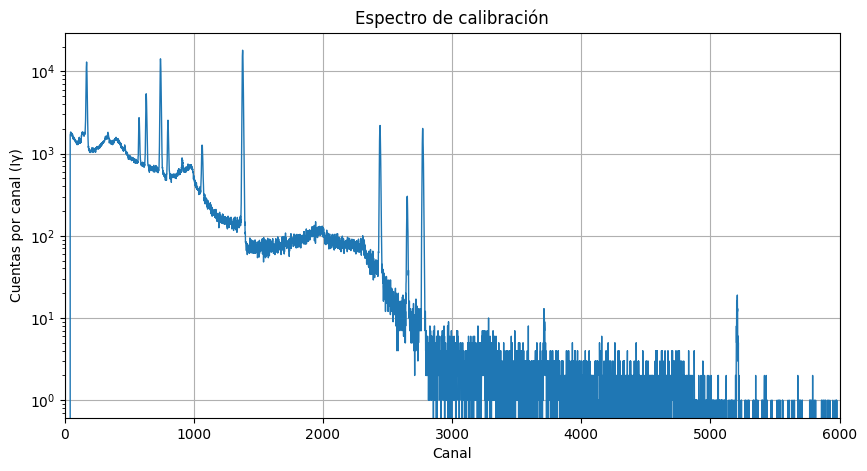

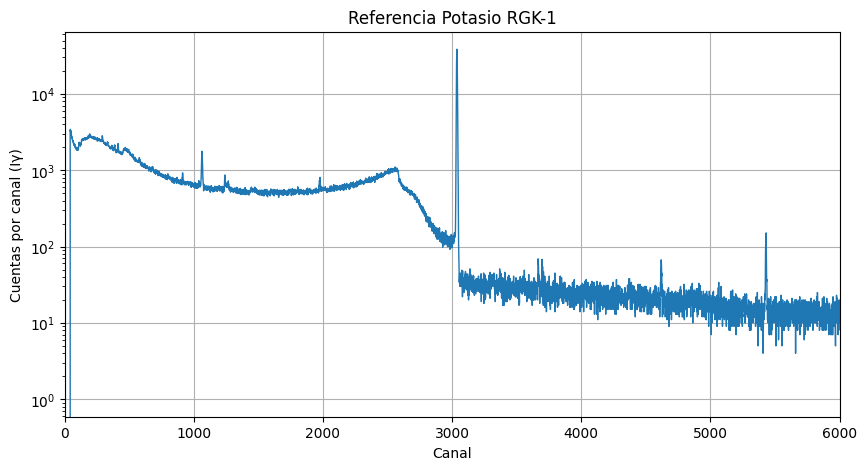

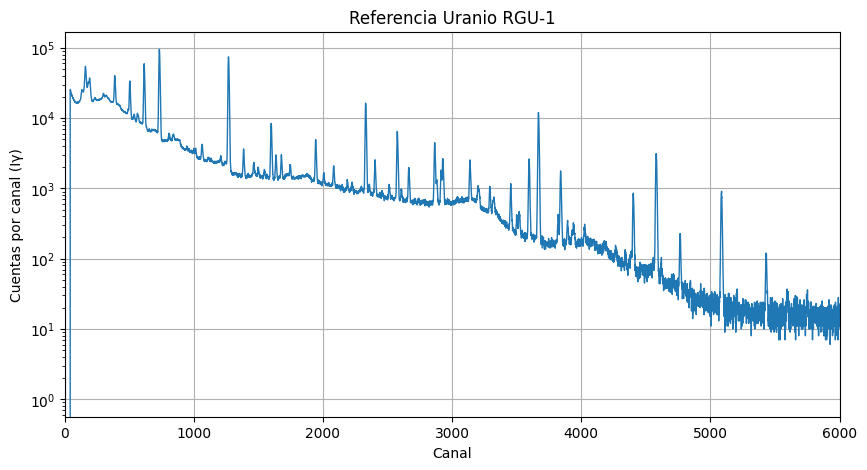

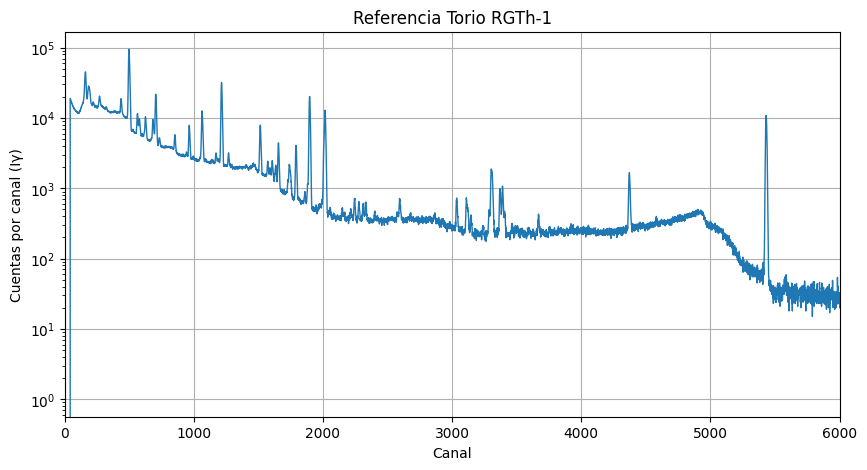

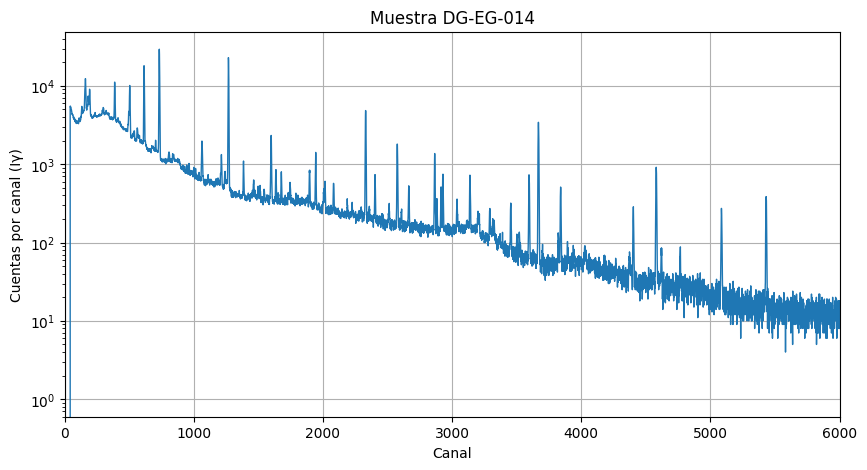

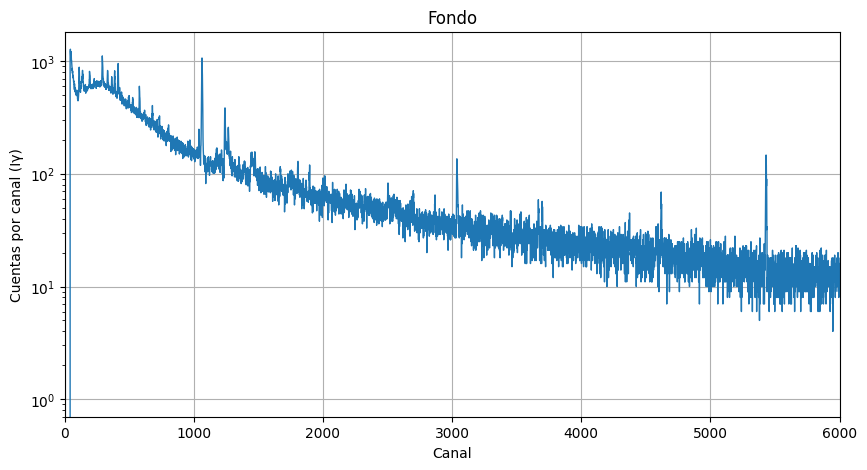

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from uncertainties import ufloat, unumpy
from lmfit.models import GaussianModel, LinearModel

plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.grid'] = True

def cargar_espectro(path):

    df = pd.read_csv(
        path,
        skiprows=1,
        header=None
    )

    df.columns = ['Channel', 'Counts']
    return df

# Función para hacer graficas
def graficar_espectro(df, titulo="Espectro gamma", color=None):
    plt.plot(df['Channel'], df['Counts'], linewidth=1, color=color)
    plt.xlabel("Canal")
    plt.ylabel("Cuentas por canal (Iγ)")
    plt.title(titulo)
    plt.xlim(0, 6000)
    plt.yscale("log")
    plt.show()


df_cal = cargar_espectro("2021-11-15_cal_133Ba22Na137Cs60Co_600s_1.csv")
df_RGK = cargar_espectro("2021-11-17_mue_IAEA-RGK-1_24h.csv")
df_RGU = cargar_espectro("2021-11-16_mue_IAEA-RGU-1_24h.csv")
df_RGTh = cargar_espectro("2021-11-15_mue_IAEA-RGTh-1_24h.csv")
df_muestra = cargar_espectro("2021-12-04_mue_DG-EG-014_24h.csv")
df_fondo = cargar_espectro("2021-12-15_fon_24h.csv")

graficar_espectro(df_cal, "Espectro de calibración")
graficar_espectro(df_RGK, "Referencia Potasio RGK-1")
graficar_espectro(df_RGU, "Referencia Uranio RGU-1")
graficar_espectro(df_RGTh, "Referencia Torio RGTh-1")
graficar_espectro(df_muestra, "Muestra DG-EG-014")
graficar_espectro(df_fondo, "Fondo")

Picos detectados (canales):
[  46   69   91  114  137  170  212  244  264  285  311  335  376  398
  420  442  465  485  506  527  551  576  604  631  659  690  710  742
  763  800  820  841  863  884  909  935  955  980 1001 1026 1064 1378
 2442 2772]


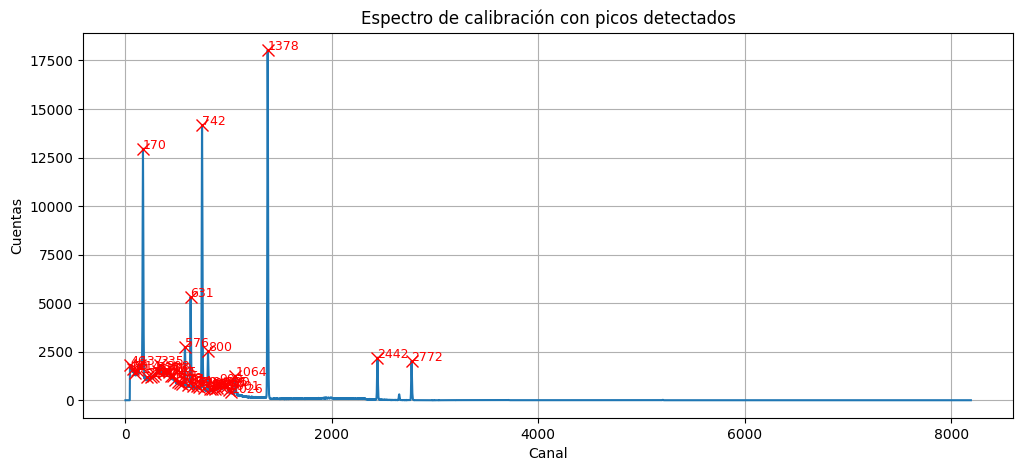

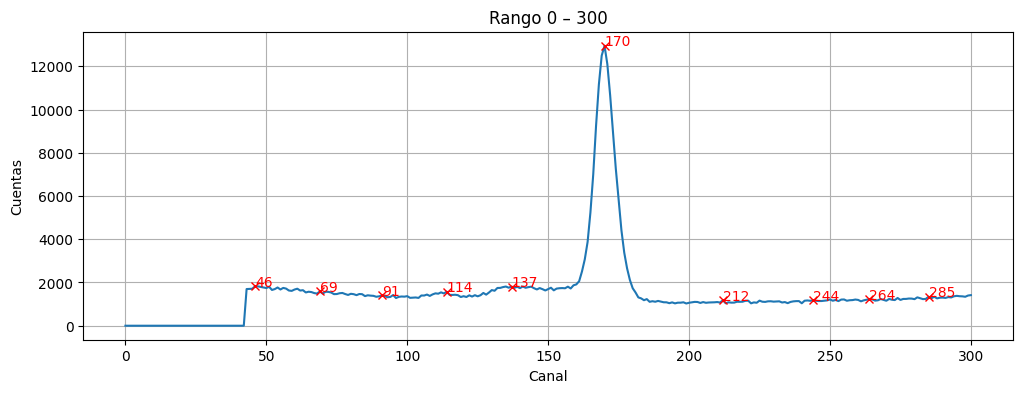

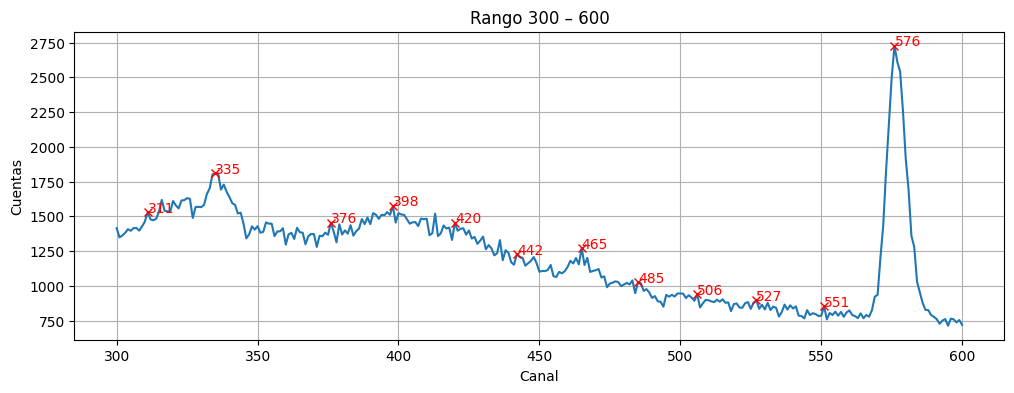

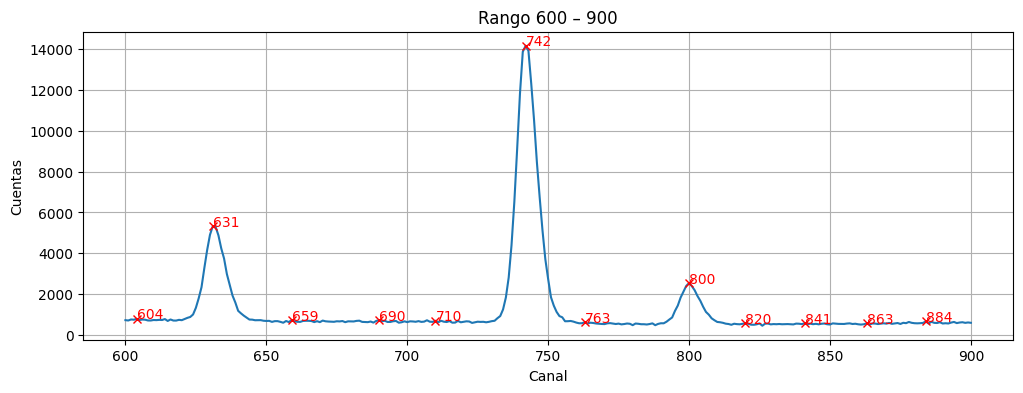

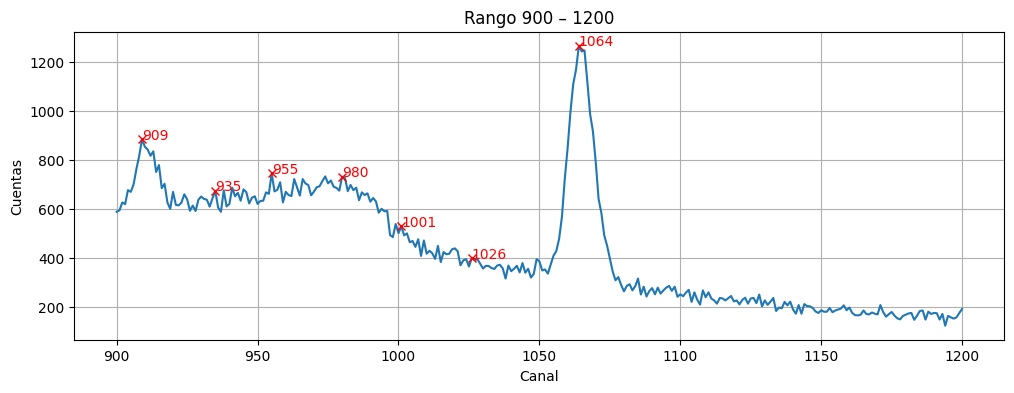

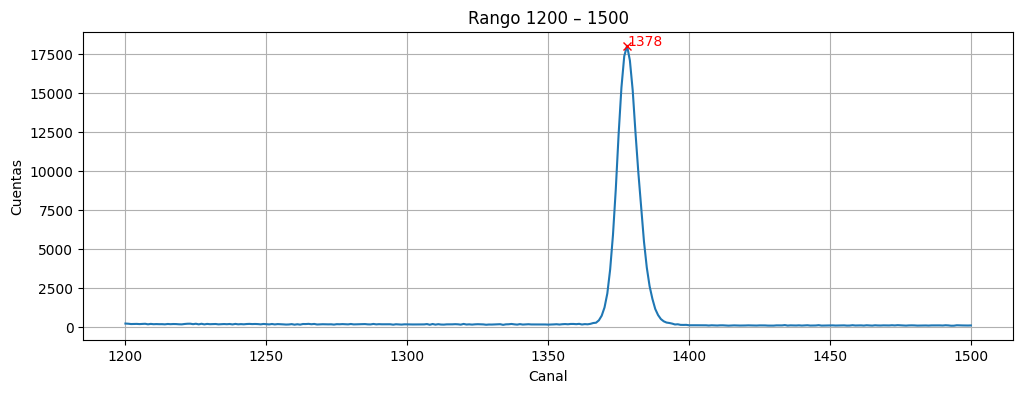

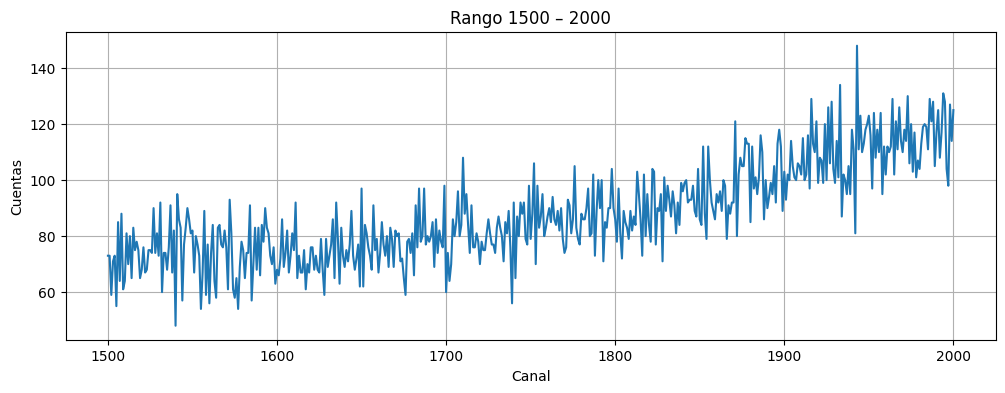

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Cargar Archivos
def cargar(path):
    df = pd.read_csv(path, skiprows=1, header=None)
    df.columns = ["Channel", "Counts"]
    return df

df = cargar("2021-11-15_cal_133Ba22Na137Cs60Co_600s_1.csv")

x = df["Channel"].values
y = df["Counts"].values

# Detección picos
# height → cuánta altura mínima debe tener un pico
# distance → mínima separación entre picos en canales
peaks, props = find_peaks(y, height=np.max(y)*0.02, distance=20)

print("Picos detectados (canales):")
print(peaks)

# Gráfica con picos señalados

plt.figure(figsize=(12,5))
plt.plot(x, y)
plt.plot(peaks, y[peaks], "rx", markersize=8)
for p in peaks:
    plt.text(p, y[p], str(p), fontsize=9, color="red")
plt.title("Espectro de calibración con picos detectados")
plt.xlabel("Canal")
plt.ylabel("Cuentas")
plt.grid(True)
plt.show()

# División por rangos

def graficar_rango(cmin, cmax):
    mask = (x >= cmin) & (x <= cmax)
    plt.figure(figsize=(12,4))
    plt.plot(x[mask], y[mask])
    # picos dentro del rango
    pr = [p for p in peaks if cmin <= p <= cmax]
    plt.plot(pr, y[pr], "rx")
    for p in pr:
        plt.text(p, y[p], str(p), color="red")
    plt.title(f"Rango {cmin} – {cmax}")
    plt.xlabel("Canal")
    plt.ylabel("Cuentas")
    plt.grid(True)
    plt.show()

rangos = [
    (0, 300),
    (300, 600),
    (600, 900),
    (900, 1200),
    (1200, 1500),
    (1500, 2000)
]

for r in rangos:
    graficar_rango(*r)


A ojo identificamos facil los del Co60 y Na22 pero el resto no está tan claro entonces hacemos un ajuste preliminar con estos 3 para tener una idea de los otros

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit.models import GaussianModel, LinearModel
from uncertainties import ufloat

def cargar(path):
    df = pd.read_csv(path, skiprows=1, header=None)
    df.columns = ['Channel','Counts']
    return df

cal = cargar("2021-11-15_cal_133Ba22Na137Cs60Co_600s_1.csv")

energias = {
    "Co1173": 1173.228,
    "Na1274": 1274.537,
    "Co1332": 1332.490
}

#Región de los picos
ventanas = {
    "Co1173": (2430, 2460),
    "Na1274": (2635, 2675),
    "Co1332": (2760, 2790)
}

picos = []

for key in energias:
    E0 = energias[key]
    cmin, cmax = ventanas[key]
    df = cal[(cal.Channel >= cmin) & (cal.Channel <= cmax)]
    x = df.Channel.values
    y = df.Counts.values

    mod = GaussianModel(prefix='g_') + LinearModel(prefix='b_')
    pars = mod.make_params()

    pars['g_center'].set(value=x[np.argmax(y)])
    pars['g_sigma'].set(value=4)
    pars['g_amplitude'].set(value=np.trapz(y, x))

    pars['b_intercept'].set(value=y.min())
    pars['b_slope'].set(value=0)

    out = mod.fit(y, pars, x=x)

    cen = out.params['g_center'].value
    err = out.params['g_center'].stderr

    picos.append((E0, cen, err))

E = np.array([p[0] for p in picos])
C = np.array([p[1] for p in picos])
dC = np.array([p[2] for p in picos])

w = 1/dC
coef = np.polyfit(C, E, 1, w=w)
a1, a0 = coef[0], coef[1]

# Incertidumbres
res = E - (a1*C + a0)
s2 = np.sum((w*res)**2) / (len(E)-2)
S = np.sum(w)
Sx = np.sum(w*C)
Delta = S*np.sum(w*C**2) - Sx**2

err_a0 = np.sqrt(s2 * np.sum(w*C**2) / Delta)
err_a1 = np.sqrt(s2 * S / Delta)

a0_u = ufloat(a0, err_a0)
a1_u = ufloat(a1, err_a1)

print("Calibración preliminar:")
print("a0 =", a0_u)
print("a1 =", a1_u)

# Función inversa para localizar picos
def canal_estimado(E):
    return (E - a0_u) / a1_u

print("\n--- Canales estimados para otros picos ---")

ener_picos_extra = {
    "Ba302": 302.8510,
    "Ba356": 356.0134,
    "Cs662": 661.657,
    "Ba80": 80.9971,
    "Ba276": 276.39,
    "Ba383": 383.84
}

for name, En in ener_picos_extra.items():
    print(name, " → canal ≈ ", canal_estimado(En))


Calibración preliminar:
a0 = -2.4+/-0.4
a1 = 0.48149+/-0.00016

--- Canales estimados para otros picos ---
Ba302  → canal ≈  634.0+/-0.9
Ba356  → canal ≈  744.4+/-0.9
Cs662  → canal ≈  1379.2+/-1.0
Ba80  → canal ≈  173.2+/-0.9
Ba276  → canal ≈  579.0+/-0.9
Ba383  → canal ≈  802.2+/-0.9


/tmp/ipython-input-3507090981.py:41: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pars['g_amplitude'].set(value=np.trapz(y, x))
/tmp/ipython-input-3507090981.py:41: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pars['g_amplitude'].set(value=np.trapz(y, x))
/tmp/ipython-input-3507090981.py:41: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pars['g_amplitude'].set(value=np.trapz(y, x))


Para la calibración usamos las energías con un b% grande y que no estén tan juntas, de forma que sea más fácil identificarlas

#Calibración

/tmp/ipython-input-3707697783.py:54: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pars['g_amplitude'].set(value=np.trapz(y, x))


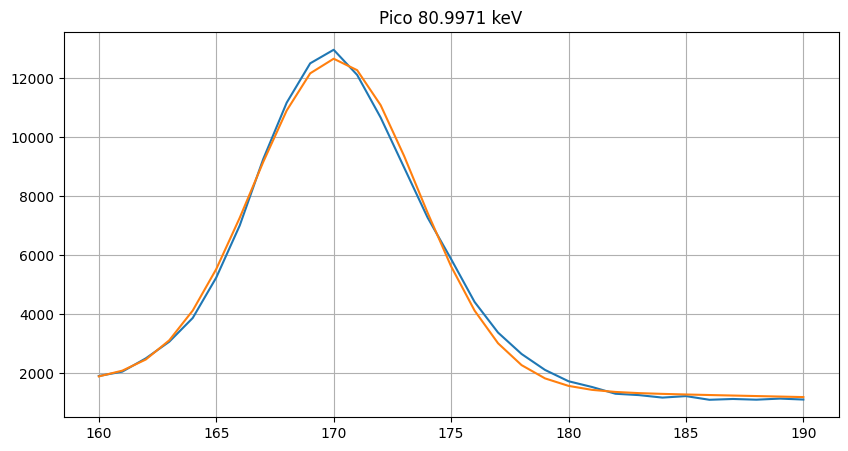

/tmp/ipython-input-3707697783.py:54: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pars['g_amplitude'].set(value=np.trapz(y, x))


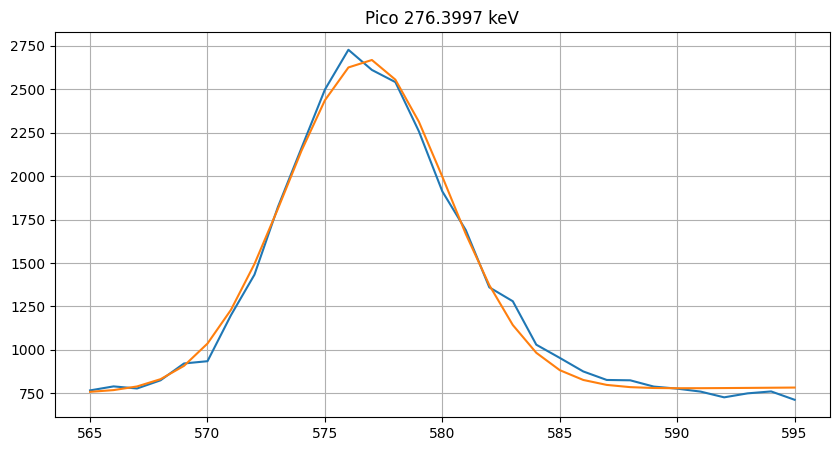

/tmp/ipython-input-3707697783.py:54: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pars['g_amplitude'].set(value=np.trapz(y, x))


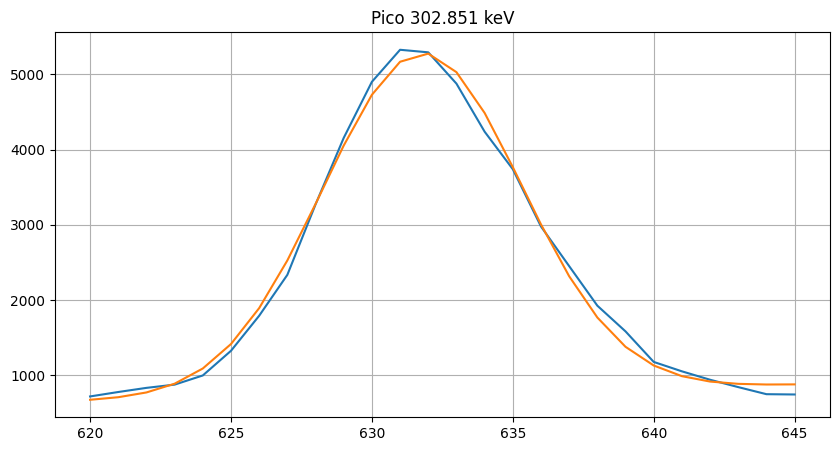

/tmp/ipython-input-3707697783.py:54: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pars['g_amplitude'].set(value=np.trapz(y, x))


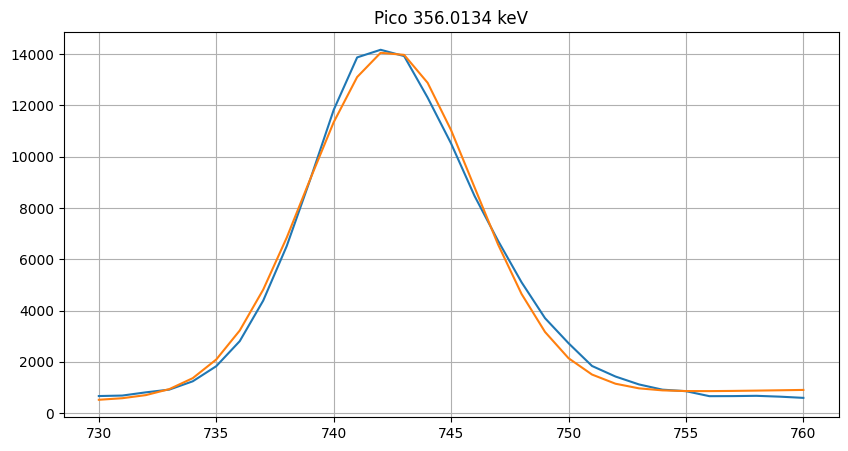

/tmp/ipython-input-3707697783.py:54: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pars['g_amplitude'].set(value=np.trapz(y, x))


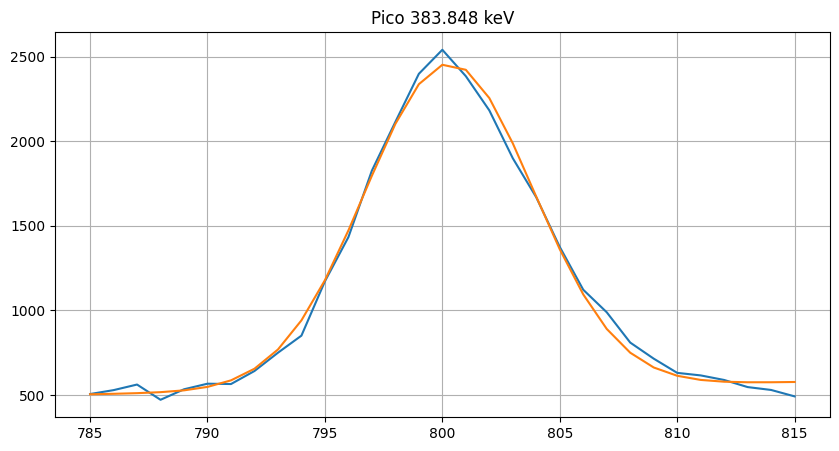

/tmp/ipython-input-3707697783.py:54: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pars['g_amplitude'].set(value=np.trapz(y, x))


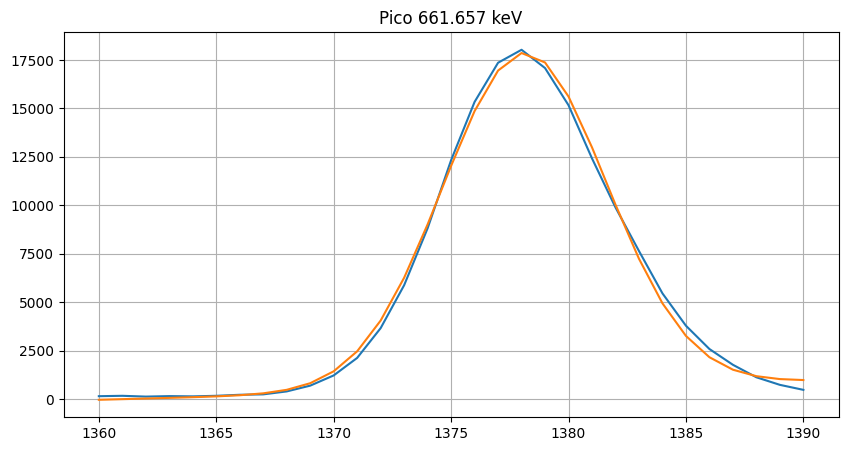

/tmp/ipython-input-3707697783.py:54: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pars['g_amplitude'].set(value=np.trapz(y, x))


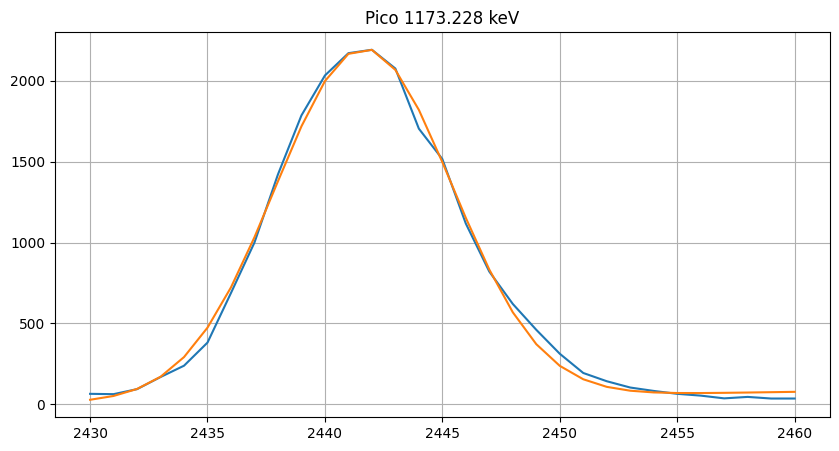

/tmp/ipython-input-3707697783.py:54: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pars['g_amplitude'].set(value=np.trapz(y, x))


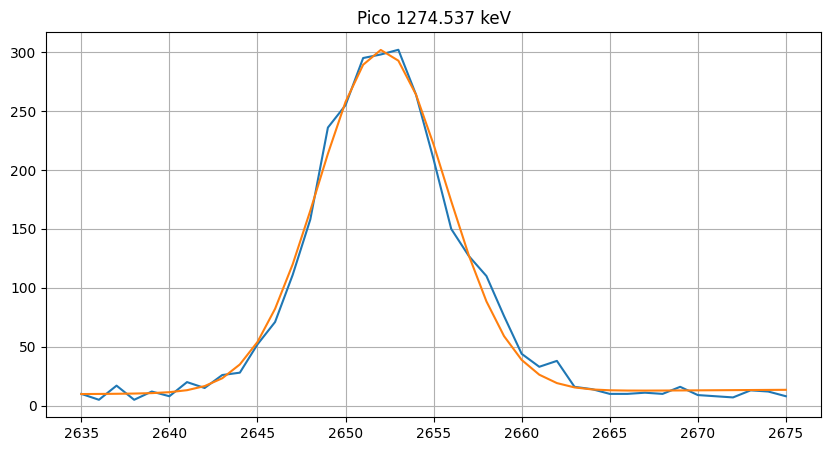

/tmp/ipython-input-3707697783.py:54: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pars['g_amplitude'].set(value=np.trapz(y, x))


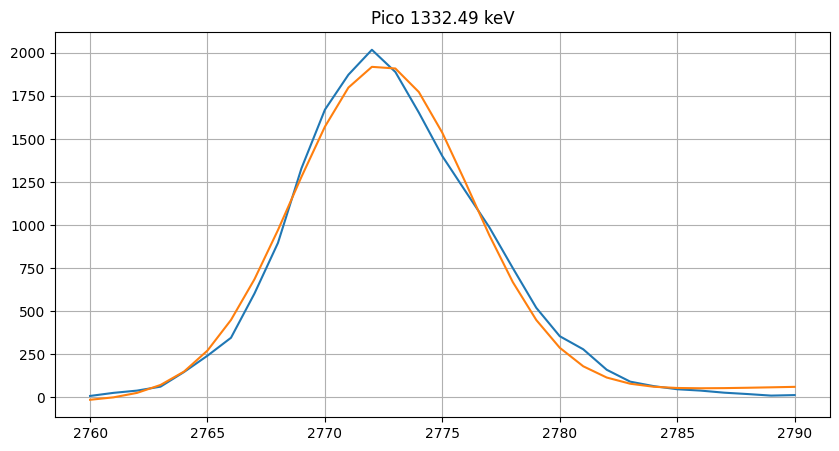

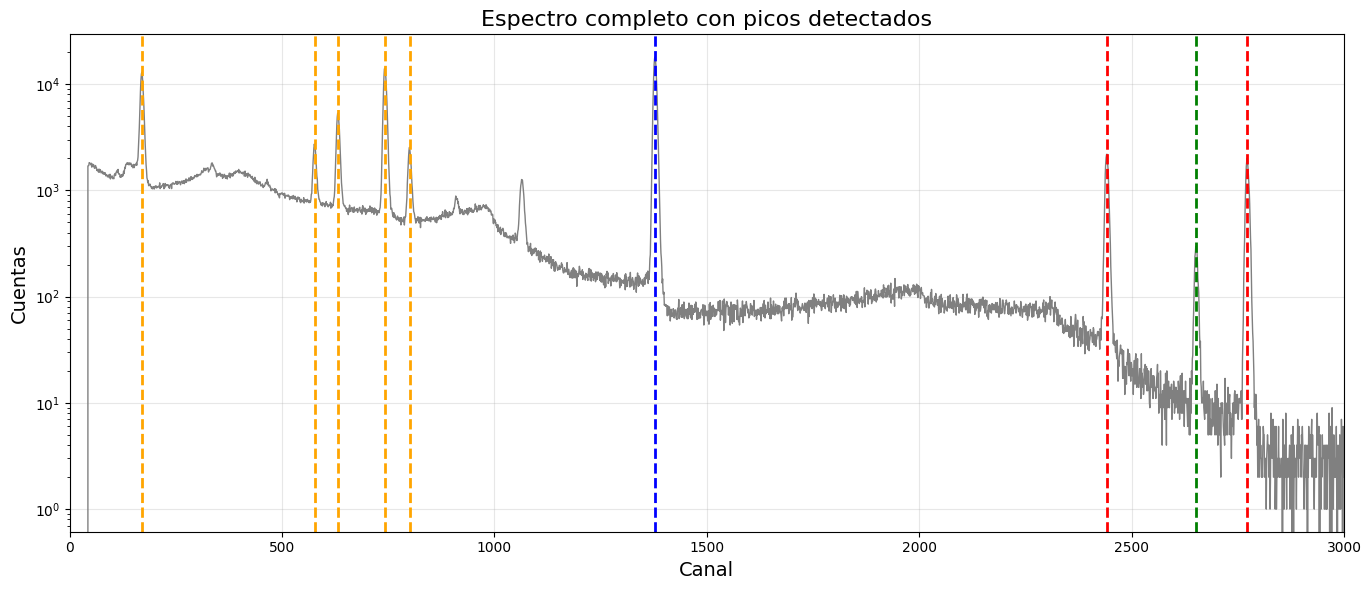

Calibración final:
a0 = -0.96+/-0.29
a1 = 0.48090+/-0.00018


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit.models import GaussianModel, LinearModel
from uncertainties import ufloat

def cargar(path):
    df = pd.read_csv(path, skiprows=1, header=None)
    df.columns = ['Channel','Counts']
    return df

cal = cargar("2021-11-15_cal_133Ba22Na137Cs60Co_600s_1.csv")

# Energías calibración
energias = {
    "Ba80": 80.9971,
    "Ba276": 276.3997,
    "Ba302": 302.8510,
    "Ba356": 356.0134,
    "Ba383": 383.8480,
    "Cs662": 661.657,
    "Co1173": 1173.228,
    "Na1274": 1274.537,
    "Co1332": 1332.490
}

# Ventanas aproximadas
ventanas = {
    "Ba80": (160, 190),
    "Ba276": (565, 595),
    "Ba302": (620, 645),
    "Ba356": (730, 760),
    "Ba383": (785, 815),
    "Cs662": (1360, 1390),
    "Co1173": (2430, 2460),
    "Na1274": (2635, 2675),
    "Co1332": (2760, 2790)
}

picos = []

for key in energias:
    E0 = energias[key]
    cmin, cmax = ventanas[key]
    df = cal[(cal.Channel >= cmin) & (cal.Channel <= cmax)]
    x = df.Channel.values
    y = df.Counts.values

    mod = GaussianModel(prefix='g_') + LinearModel(prefix='b_')
    pars = mod.make_params()

    pars['g_center'].set(value=x[np.argmax(y)])
    pars['g_sigma'].set(value=4)
    pars['g_amplitude'].set(value=np.trapz(y, x))

    pars['b_intercept'].set(value=y.min())
    pars['b_slope'].set(value=0)

    out = mod.fit(y, pars, x=x)

    cen = out.params['g_center'].value
    err = out.params['g_center'].stderr

    picos.append((E0, cen, err))

    plt.plot(x,y)
    plt.plot(x,out.best_fit)
    plt.title(f"Pico {E0} keV")
    plt.show()

E = np.array([p[0] for p in picos])
C = np.array([p[1] for p in picos])
dC = np.array([p[2] for p in picos])

w = 1/dC
coef = np.polyfit(C, E, 1, w=w)
a1, a0 = coef[0], coef[1]

res = E - (a1*C + a0)
s2 = np.sum((w*res)**2) / (len(E)-2)
S = np.sum(w)
Sx = np.sum(w*C)
Delta = S*np.sum(w*C**2) - Sx**2

err_a0 = np.sqrt(s2 * np.sum(w*C**2) / Delta)
err_a1 = np.sqrt(s2 * S / Delta)

a0_u = ufloat(a0, err_a0)
a1_u = ufloat(a1, err_a1)

#Gráfica con picos señalados

plt.figure(figsize=(14,6))
plt.plot(cal.Channel, cal.Counts, color='gray', linewidth=1, label="Espectro completo")

nombres_nuclidos = {
    "Ba80": "Ba-133",
    "Ba276": "Ba-133",
    "Ba302": "Ba-133",
    "Ba356": "Ba-133",
    "Ba383": "Ba-133",
    "Cs662": "Cs-137",
    "Co1173": "Co-60",
    "Na1274": "Na-22",
    "Co1332": "Co-60"
}

colores = {
    "Ba-133": "orange",
    "Cs-137": "blue",
    "Co-60": "red",
    "Na-22": "green"
}

ya_mostrado = set()

for key in energias:
    nombre = nombres_nuclidos[key]
    color = colores[nombre]

    # Buscar el centro del pico correspondiente
    for p in picos:
        if p[0] == energias[key]:
            E0, cen, err = p

            plt.axvline(cen, color=color, linestyle='--', linewidth=2)

            if nombre not in ya_mostrado:
                plt.plot([], [], color=color, label=nombre)
                ya_mostrado.add(nombre)


plt.xlabel("Canal", fontsize=14)
plt.ylabel("Cuentas", fontsize=14)
plt.title("Espectro completo con picos detectados", fontsize=16)
plt.grid(alpha=0.3)
plt.xlim(0, 3000)
plt.tight_layout()
plt.yscale("log")
plt.show()


print("Calibración final:")
print("a0 =", a0_u)
print("a1 =", a1_u)


#Conversión a E y resta de fondo

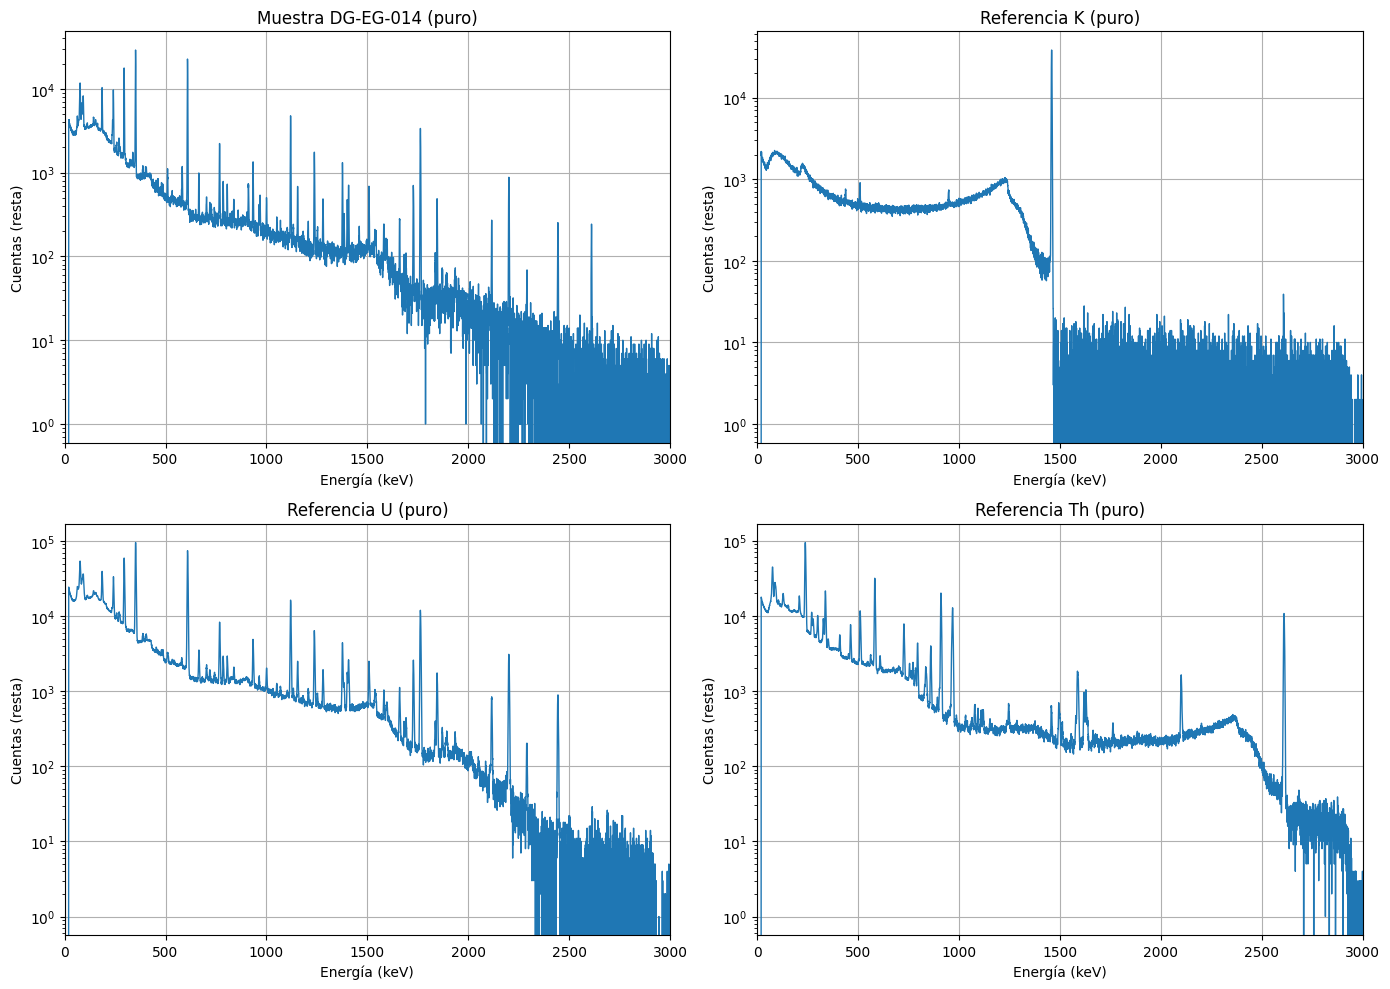

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calibración
a0 = -0.96
a1 = 0.48090

def cargar(path):
    df = pd.read_csv(path, skiprows=1, header=None)
    df.columns = ["Channel", "Counts"]
    return df

def convertir_energia(df):
    df2 = df.copy()
    df2["Energy_keV"] = a0 + a1 * df["Channel"]
    return df2

def espectro_resta(df, fondo):
    out = df.copy()
    out["Counts"] = df["Counts"] - fondo["Counts"]
    return out

# Cargar archivos
fondo = cargar("2021-12-15_fon_24h.csv")
muestra = cargar("2021-12-04_mue_DG-EG-014_24h.csv")
ref_K  = cargar("2021-11-17_mue_IAEA-RGK-1_24h.csv")
ref_U  = cargar("2021-11-16_mue_IAEA-RGU-1_24h.csv")
ref_Th = cargar("2021-11-15_mue_IAEA-RGTh-1_24h.csv")

# Espectros resta
m_pura  = espectro_resta(muestra, fondo)
K_pura  = espectro_resta(ref_K, fondo)
U_pura  = espectro_resta(ref_U, fondo)
Th_pura = espectro_resta(ref_Th, fondo)

# Convertir a energía
m_pura_E  = convertir_energia(m_pura)
K_pura_E  = convertir_energia(K_pura)
U_pura_E  = convertir_energia(U_pura)
Th_pura_E = convertir_energia(Th_pura)


fig, axs = plt.subplots(2, 2, figsize=(14,10))
axs = axs.flatten()

datasets = [
    (m_pura_E,  "Muestra DG-EG-014 (puro)"),
    (K_pura_E,  "Referencia K (puro)"),
    (U_pura_E,  "Referencia U (puro)"),
    (Th_pura_E, "Referencia Th (puro)")
]

for ax, (df, titulo) in zip(axs, datasets):
    ax.plot(df["Energy_keV"], df["Counts"], linewidth=1.0)
    ax.set_xlabel("Energía (keV)")
    ax.set_ylabel("Cuentas (resta)")
    ax.set_title(titulo)
    ax.grid(True)
    ax.set_xlim(0, 3000)
    ax.set_yscale("log")

plt.tight_layout()
plt.show()


#Analisis Potasio-40 (Pico 1461 keV)

/tmp/ipython-input-693719868.py:45: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pars[f"g_{etiqueta}_amplitude"].set(value=np.trapz(N, E))


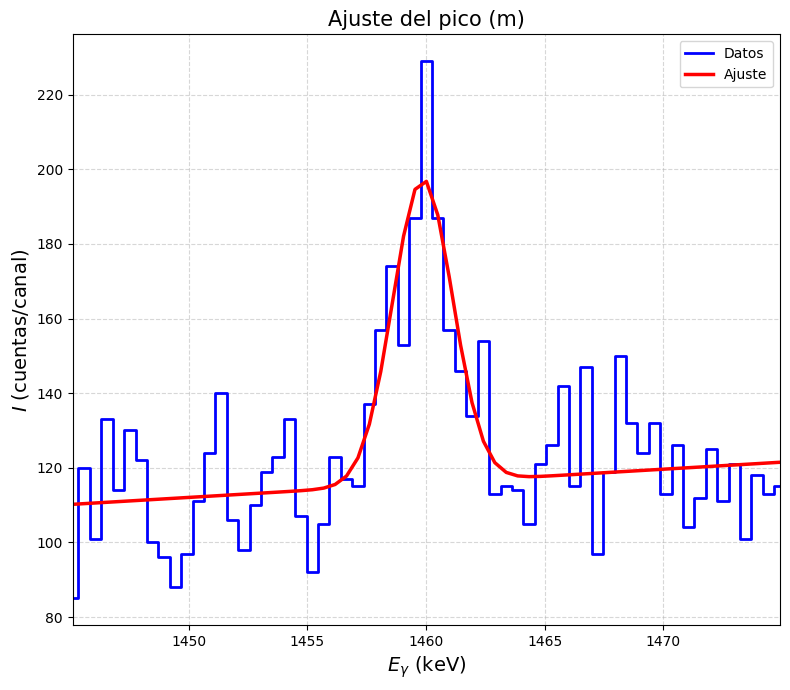

/tmp/ipython-input-693719868.py:45: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pars[f"g_{etiqueta}_amplitude"].set(value=np.trapz(N, E))


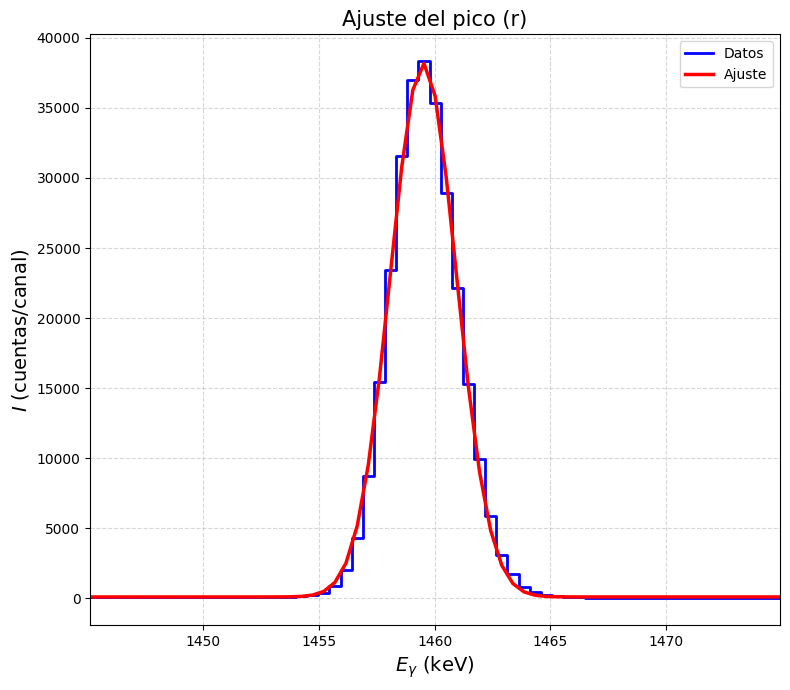

C_m (fracción másica): 0.00085(18)
C_m (%):               0.085(18)
C_m (ppm):             8.5(1.8)e+02
      A = 12.68±3.17 Bq



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit.models import GaussianModel, LinearModel
from uncertainties import ufloat

# Calibración
a0 = -0.96
a1 = 0.48090

def cargar(path):
    df = pd.read_csv(path, skiprows=1, header=None)
    df.columns = ["canal", "cuentas"]
    return df

def espectro_resta(df_m, df_fondo):
    out = df_m.copy()
    out["cuentas"] = df_m["cuentas"] - df_fondo["cuentas"]
    return out

def energia(df):
    out = df.copy()
    out["E_keV"] = a0 + a1 * df["canal"]
    return out

# Ajuste del pico

def ajustar_pico(df, Emin, Emax, etiqueta="m"):
    """
    Ajuste gaussiano en energía.
    Devuelve parámetros y sus errores.
    """

    ventana = (df["E_keV"] >= Emin) & (df["E_keV"] <= Emax)
    d = df[ventana]

    E = d["E_keV"].values
    N = d["cuentas"].values

    mod = GaussianModel(prefix=f"g_{etiqueta}_") + LinearModel(prefix=f"b_{etiqueta}_")
    pars = mod.make_params()

    pars[f"g_{etiqueta}_center"].set(value=E[np.argmax(N)])
    pars[f"g_{etiqueta}_sigma"].set(value=3)
    pars[f"g_{etiqueta}_amplitude"].set(value=np.trapz(N, E))

    pars[f"b_{etiqueta}_intercept"].set(value=N.min())
    pars[f"b_{etiqueta}_slope"].set(value=0)

    out = mod.fit(N, pars, x=E)

    # Parámetros
    E0 = out.params[f"g_{etiqueta}_center"].value
    sigmaE = out.params[f"g_{etiqueta}_sigma"].value
    sigmaE_err = out.params[f"g_{etiqueta}_sigma"].stderr

    A = out.params[f"g_{etiqueta}_amplitude"].value
    A_err = out.params[f"g_{etiqueta}_amplitude"].stderr

    sigma = out.params[f"g_{etiqueta}_sigma"].value
    sigma_err = out.params[f"g_{etiqueta}_sigma"].stderr

    A_u = ufloat(A, A_err)
    sigma_u = ufloat(sigma, sigma_err)

    Y_u = A_u / (sigma_u * np.sqrt(2*np.pi))


    # σ en canales
    sigmaC = sigmaE / a1
    sigmaC_err = sigmaE_err / a1

    sigmaC_u = ufloat(sigmaC, sigmaC_err)

    # Intensidad integrada
    I_u = np.sqrt(2*np.pi) * sigmaC_u * Y_u

    # Gráfica
    plt.figure(figsize=(8,7))
    plt.step(E, N, where="mid", color="blue", linewidth=2, label="Datos")
    plt.plot(E, out.best_fit, color="red", linewidth=2.5, label="Ajuste")

    plt.xlabel(r"$E_\gamma$ (keV)", fontsize=14)
    plt.ylabel(r"$I$ (cuentas/canal)", fontsize=14)
    plt.title(f"Ajuste del pico ({etiqueta})", fontsize=15)

    plt.grid(True, linestyle="--", alpha=0.5)
    plt.xlim(E.min(), E.max())
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        f"sigmaE_{etiqueta}": sigmaE,
        f"sigmaC_{etiqueta}": sigmaC,
        f"Y_{etiqueta}": Y_u,
        f"I_{etiqueta}": I_u.nominal_value,
        f"Ierr_{etiqueta}": I_u.std_dev,
        f"Iu_{etiqueta}": I_u
    }


# Carga de archivos

fondo = cargar("2021-12-15_fon_24h.csv")
m      = cargar("2021-12-04_mue_DG-EG-014_24h.csv")
r_K    = cargar("2021-11-17_mue_IAEA-RGK-1_24h.csv")

m_pura = espectro_resta(m, fondo)
r_pura = espectro_resta(r_K, fondo)

m_E = energia(m_pura)
r_E = energia(r_pura)


I_m = ajustar_pico(m_E, 1445, 1475, etiqueta="m")
I_r = ajustar_pico(r_E, 1445, 1475, etiqueta="r")

# Concentración de 40K

from uncertainties import ufloat

I_m_u = I_m["Iu_m"]
I_r_u = I_r["Iu_r"]

C_r = ufloat(0.448, 0.003)

C_m = (I_m_u / I_r_u) * C_r

# Conversión a por ciento
C_m_percent = C_m * 100

# Conversión a ppm (1% = 10^4 ppm)
C_m_ppm = C_m_percent * 1e4

print(f"C_m (fracción másica): {C_m:.2uS}")
print(f"C_m (%):               {C_m_percent:.2uS}")
print(f"C_m (ppm):             {C_m_ppm:.2uS}")

from uncertainties import ufloat
import numpy as np

#Actividad

NA = 6.02214076e23  # Numero de Avogadro
M_K = 39.1          # Masa molar del potasio (g/mol)
phi_40K = 0.000117  # Fracción isotópica de 40K
T12_years = 1.248e9 # Vida media en años

T12_s = T12_years * 365.25 * 24 * 3600

lambda_K = 0.693 / T12_s

C_m_u = ufloat(0.0008,0.0002)

masa_muestra_g = 500.0

A_u = lambda_K * NA/M_K * phi_40K * C_m_u * masa_muestra_g

print(f"      A = {A_u:.3uP} Bq\n")



#Analisis Uranio-238 (Pico 352 keV)

/tmp/ipython-input-2831572703.py:41: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pars["g_amplitude"].set(value=np.trapz(N, E))


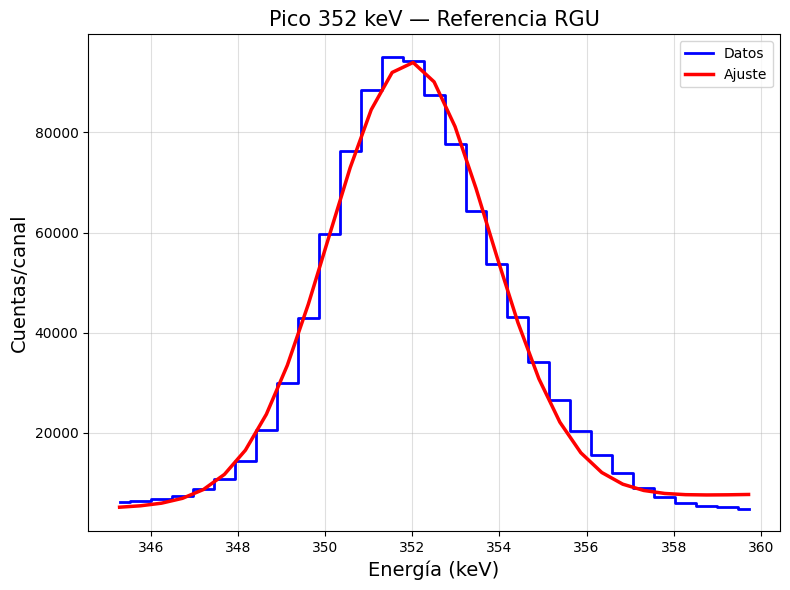


=== Resultados (Referencia RGU) — 352 keV ===
Centro: 351.93491075654646 ± 0.03526808725567839
σ (keV): 1.84+/-0.04
Y (cuentas/canal): (4.23+/-0.15)e+04
I (cuentas): (4.07+/-0.11)e+05



/tmp/ipython-input-2831572703.py:41: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pars["g_amplitude"].set(value=np.trapz(N, E))


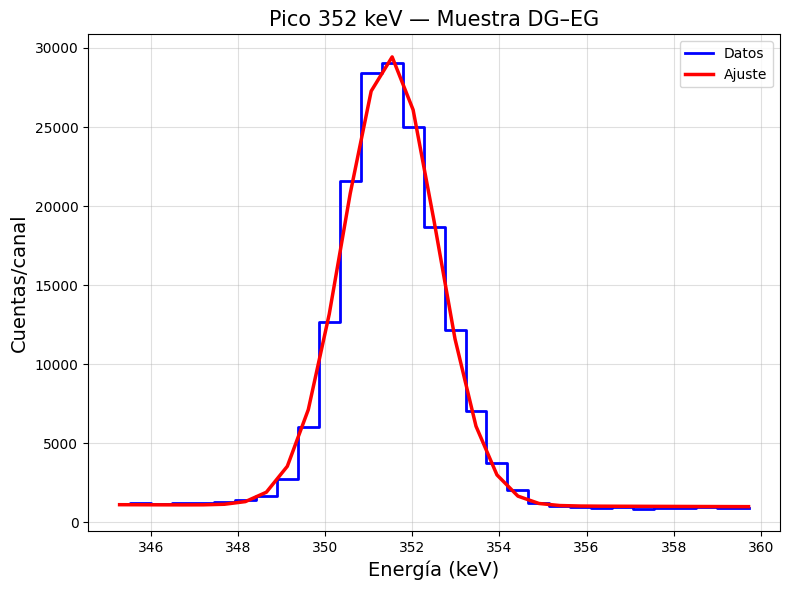


=== Resultados (Muestra DG–EG) — 352 keV ===
Centro: 351.4858116351409 ± 0.014838794022575052
σ (keV): 1.063+/-0.016
Y (cuentas/canal): (1.366+/-0.030)e+04
I (cuentas): (7.57+/-0.12)e+04

   Espectro        σ(keV)        Y(10^3 c/canal)        I(10^3 cuentas)
--------------------------------------------------------------------------
Referencia RGU   1.845(42)     42.3(1.5)          407(11)
Muestra DG–EG    1.063(16)     13.66(30)          75.7(1.2)
Actividad (Bq) = 460+/-14
Actividad (Bq/kg) = 919+/-28
Concentracion = (7.45+/-0.23)e-05


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit.models import GaussianModel, LinearModel
from uncertainties import ufloat


# Calibración
a0 = ufloat(-0.96, 0.29)
a1 = ufloat(0.48090, 0.00018)

def cargar(path):
    df = pd.read_csv(path, skiprows=1, header=None)
    df.columns = ["canal", "cuentas"]
    return df

def restar_fondo(df, fondo):
    out = df.copy()
    out["cuentas"] = df["cuentas"] - fondo["cuentas"]
    out["cuentas"] = out["cuentas"].clip(lower=0)
    return out

def a_energia(df):
    out = df.copy()
    out["E_keV"] = a0.nominal_value + a1.nominal_value * df["canal"]
    return out

def ajustar_pico_352(df, etiqueta="muestra"):
    Emin, Emax = 345, 360
    mask = (df["E_keV"] >= Emin) & (df["E_keV"] <= Emax)
    d = df[mask]

    E = d["E_keV"].values
    N = d["cuentas"].values

    mod = GaussianModel(prefix="g_") + LinearModel(prefix="b_")
    pars = mod.make_params()

    pars["g_center"].set(value=E[np.argmax(N)], min=348, max=356)
    pars["g_sigma"].set(value=2.5)
    pars["g_amplitude"].set(value=np.trapz(N, E))

    pars["b_intercept"].set(value=N.min())
    pars["b_slope"].set(value=0)

    out = mod.fit(N, pars, x=E)

    # Parámetros
    cen = out.params["g_center"].value
    cen_err = out.params["g_center"].stderr or 0.1

    sigma_E = out.params["g_sigma"].value
    sigma_E_err = out.params["g_sigma"].stderr or 0.1

    A = out.params["g_amplitude"].value
    A_err = out.params["g_amplitude"].stderr or 0.1

    # Convertir a ufloats
    sigma_E_u = ufloat(sigma_E, sigma_E_err)
    sigma_C_u = sigma_E_u / a1

    A_u = ufloat(A, A_err)

    Y_u = A_u / (sigma_C_u * np.sqrt(2*np.pi))
    I_u = np.sqrt(2*np.pi) * sigma_C_u * Y_u

    # Gráfica
    plt.figure(figsize=(8,6))
    plt.step(E, N, where="mid", color="blue", linewidth=2, label="Datos")
    plt.plot(E, out.best_fit, color="red", linewidth=2.5, label="Ajuste")
    plt.xlabel("Energía (keV)", fontsize=14)
    plt.ylabel("Cuentas/canal", fontsize=14)
    plt.title(f"Pico 352 keV — {etiqueta}", fontsize=15)
    plt.grid(True, alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


    print(f"\n=== Resultados ({etiqueta}) — 352 keV ===")
    print("Centro:", cen, "±", cen_err)
    print("σ (keV):", sigma_E_u)
    print("Y (cuentas/canal):", Y_u)
    print("I (cuentas):", I_u)
    print("=========================================\n")

    return {
        "sigmaE_u": sigma_E_u,
        "Y_u": Y_u,
        "I_u": I_u
    }

# Carga de archivos

fondo = cargar("2021-12-15_fon_24h.csv")
muestra = cargar("2021-12-04_mue_DG-EG-014_24h.csv")
referencia = cargar("2021-11-16_mue_IAEA-RGU-1_24h.csv")

muestra_pura = restar_fondo(muestra, fondo)
referencia_pura = restar_fondo(referencia, fondo)

muestra_E = a_energia(muestra_pura)
referencia_E = a_energia(referencia_pura)

# Ajustes

res_r = ajustar_pico_352(referencia_E, "Referencia RGU")
res_m = ajustar_pico_352(muestra_E, "Muestra DG–EG")

I_r = res_r["I_u"]
I_m = res_m["I_u"]

print("   Espectro        σ(keV)        Y(10^3 c/canal)        I(10^3 cuentas)")
print("--------------------------------------------------------------------------")

print(f"Referencia RGU   {res_r['sigmaE_u']:.2uS}     {(res_r['Y_u']/1e3):.2uS}          {(res_r['I_u']/1e3):.2uS}")
print(f"Muestra DG–EG    {res_m['sigmaE_u']:.2uS}     {(res_m['Y_u']/1e3):.2uS}          {(res_m['I_u']/1e3):.2uS}")

# Actividad

A_r = ufloat(10750, 200)

C_r = ufloat(0.000400,0.000002)

C_m = (I_m / I_r) * C_r

NA = 6.02214076e23      # Número de Avogadro
M_U = 238.0289          # Masa molar del uranio (g/mol)
phi_U238 = 0.992742     # Fracción isotópica del 238U
T12_years_U238 = 4.468e9  # Vida media en años

T12_s_U238 = T12_years_U238 * 365.25 * 24 * 3600

lambda_U238 = 0.693 / T12_s_U238

masa_muestra_g = 500.0

A_ec = lambda_U238 * (NA / M_U) * phi_U238 * C_m * masa_muestra_g

print("Actividad (Bq) =", A_ec)
print("Actividad (Bq/kg) =", A_ec / (masa_muestra_g/1000))
print("Concentracion =", C_m)


#Analisis Torio-232 (Pico 2615 keV)

/tmp/ipython-input-193158976.py:40: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pars["g_amplitude"].set(value=np.trapz(N, E))


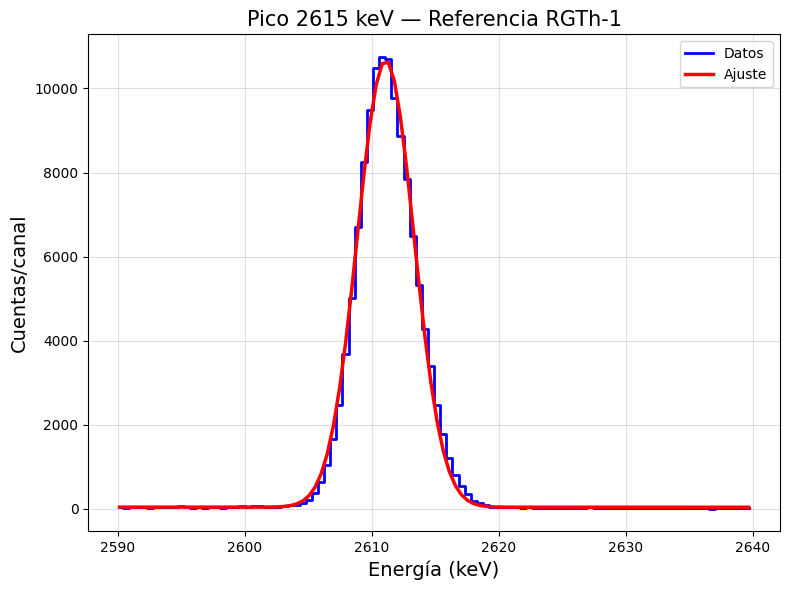


=== RESULTADOS (Referencia RGTh-1) — 2615 keV ===
Centro: 2611.0824042654035 ± 0.015459842155886389
σ (keV): 2.230+/-0.016
Y (cuentas/canal): (5.11+/-0.05)e+03
I (cuentas): (5.94+/-0.04)e+04



/tmp/ipython-input-193158976.py:40: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pars["g_amplitude"].set(value=np.trapz(N, E))


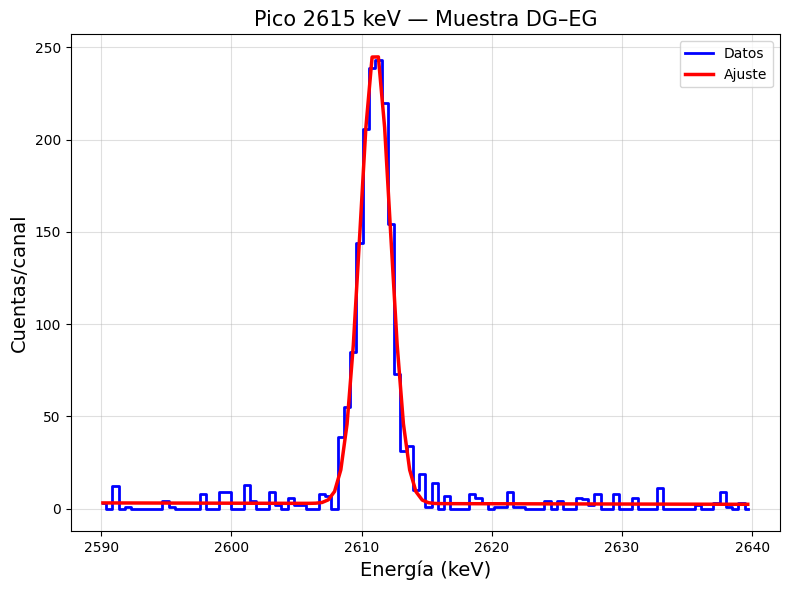


=== RESULTADOS (Muestra DG–EG) — 2615 keV ===
Centro: 2611.049224407403 ± 0.017057558285154064
σ (keV): 1.158+/-0.017
Y (cuentas/canal): 118.9+/-2.4
I (cuentas): 718+/-10

   Espectro        σ(keV)        Y(10^3 c/canal)        I(10^3 cuentas)
--------------------------------------------------------------------------
Referencia RGTh   2.230(16)     5.109(51)          59.38(41)
Muestra DG–EG     1.158(17)     0.1189(24)          0.7178(98)
===== CONCENTRACIÓN DE Th-232 =====
C_m = (9.67+/-0.24)e-06
C_m (%) = 0.000967+/-0.000024
C_m (ppm) = 9.67+/-0.24

Actividad total (Bq) = 19.6+/-0.5
Actividad (Bq/kg) = 39.2+/-1.0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit.models import GaussianModel, LinearModel
from uncertainties import ufloat

# Calibración
a0 = ufloat(-0.96, 0.29)
a1 = ufloat(0.48090, 0.00018)

def cargar(path):
    df = pd.read_csv(path, skiprows=1, header=None)
    df.columns = ["canal", "cuentas"]
    return df

def restar_fondo(df, fondo):
    out = df.copy()
    out["cuentas"] = df["cuentas"] - fondo["cuentas"]
    out["cuentas"] = out["cuentas"].clip(lower=0)
    return out

def a_energia(df):
    out = df.copy()
    out["E_keV"] = a0.nominal_value + a1.nominal_value * df["canal"]
    return out

def ajustar_pico_2615(df, etiqueta="muestra"):
    Emin, Emax = 2590, 2640
    mask = (df["E_keV"] >= Emin) & (df["E_keV"] <= Emax)
    d = df[mask]

    E = d["E_keV"].values
    N = d["cuentas"].values

    mod = GaussianModel(prefix="g_") + LinearModel(prefix="b_")
    pars = mod.make_params()

    pars["g_center"].set(value=E[np.argmax(N)], min=2600, max=2630)
    pars["g_sigma"].set(value=4.0)
    pars["g_amplitude"].set(value=np.trapz(N, E))

    pars["b_intercept"].set(value=N.min())
    pars["b_slope"].set(value=0)

    out = mod.fit(N, pars, x=E)

    cen = out.params["g_center"].value
    cen_err = out.params["g_center"].stderr or 0.2

    sigma_E = out.params["g_sigma"].value
    sigma_E_err = out.params["g_sigma"].stderr or 0.2

    A = out.params["g_amplitude"].value
    A_err = out.params["g_amplitude"].stderr or 0.2

    sigma_E_u = ufloat(sigma_E, sigma_E_err)
    sigma_C_u = sigma_E_u / a1
    A_u = ufloat(A, A_err)

    # Parámetros guía
    Y_u = A_u / (sigma_C_u * np.sqrt(2*np.pi))
    I_u = np.sqrt(2*np.pi) * sigma_C_u * Y_u

    # Gráfica
    plt.figure(figsize=(8,6))
    plt.step(E, N, where="mid", color="blue", linewidth=2, label="Datos")
    plt.plot(E, out.best_fit, color="red", linewidth=2.5, label="Ajuste")
    plt.xlabel("Energía (keV)", fontsize=14)
    plt.ylabel("Cuentas/canal", fontsize=14)
    plt.title(f"Pico 2615 keV — {etiqueta}", fontsize=15)
    plt.grid(True, alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"\n=== RESULTADOS ({etiqueta}) — 2615 keV ===")
    print("Centro:", cen, "±", cen_err)
    print("σ (keV):", sigma_E_u)
    print("Y (cuentas/canal):", Y_u)
    print("I (cuentas):", I_u)
    print("=========================================\n")

    return {
        "sigmaE_u": sigma_E_u,
        "Y_u": Y_u,
        "I_u": I_u
    }

# Carga de archivos

fondo = cargar("2021-12-15_fon_24h.csv")
muestra = cargar("2021-12-04_mue_DG-EG-014_24h.csv")
referencia = cargar("2021-11-15_mue_IAEA-RGTh-1_24h.csv")

muestra_pura = restar_fondo(muestra, fondo)
referencia_pura = restar_fondo(referencia, fondo)

muestra_E = a_energia(muestra_pura)
referencia_E = a_energia(referencia_pura)

res_r = ajustar_pico_2615(referencia_E, "Referencia RGTh-1")
res_m = ajustar_pico_2615(muestra_E, "Muestra DG–EG")

I_r = res_r["I_u"]
I_m = res_m["I_u"]

print("   Espectro        σ(keV)        Y(10^3 c/canal)        I(10^3 cuentas)")
print("--------------------------------------------------------------------------")
print(f"Referencia RGTh   {res_r['sigmaE_u']:.2uS}     {(res_r['Y_u']/1e3):.2uS}          {(res_r['I_u']/1e3):.2uS}")
print(f"Muestra DG–EG     {res_m['sigmaE_u']:.2uS}     {(res_m['Y_u']/1e3):.2uS}          {(res_m['I_u']/1e3):.2uS}")

# Concentración
C_r = ufloat(0.000800, 0.000016)

C_m = (I_m / I_r) * C_r

print("===== CONCENTRACIÓN DE Th-232 =====")
print("C_m =", C_m)
print("C_m (%) =", C_m * 100)
print("C_m (ppm) =", C_m * 1e6)
print("=================================================\n")

# Actividad

NA = 6.02214076e23 # Número de Avogadro
M_Th = 232.038 # Masa molar del Torio (g/mol)
phi_Th232 = 1.0 # Fracción isotópica del 232Th
T12_years_Th = 1.405e10 # Vida media en años
T12_s_Th = T12_years_Th * 365.25 * 24 * 3600
lambda_Th = 0.693 / T12_s_Th

masa_muestra_g = 500.0

A_ec = lambda_Th * (NA / M_Th) * phi_Th232 * C_m * masa_muestra_g

print("Actividad total (Bq) =", A_ec)
print("Actividad (Bq/kg) =", A_ec / (masa_muestra_g/1000))